# RecB dissociation rates in ΔrecA and RecB1080

In [1]:
from pyberries.data import DatasetPool
import seaborn.objects as so

data = (DatasetPool(path='D:\DanielThedie\BACMMAN\Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1',
                            '230201_DT22', '230919_1', '240424_3',
                            '230126_DT21', '230919_2', '230920_2',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2',
                            '221222_cipro30ngmL', '230802_DT22', '230808_DT22', '230914_1', '240424_4',
                            '230802_DT21', '230913_2', '230914_2',
                            '240116_1', '240116_2', '240116_3',
                            '240117_1', '240117_2', '240117_3', '240117_4'],
                    groups=['WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0',
                            '$\Delta$recA, 0', '$\Delta$recA, 0', '$\Delta$recA, 0',
                            'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0',
                            'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL',
                            '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL',
                            'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL',
                            'RecB1080-$\Delta$recA, 0', 'RecB1080-$\Delta$recA, 0', 'RecB1080-$\Delta$recA, 0',
                            'RecB1080-$\Delta$recA, 30 ng/mL', 'RecB1080-$\Delta$recA, 30 ng/mL', 'RecB1080-$\Delta$recA, 30 ng/mL', 'RecB1080-$\Delta$recA, 30 ng/mL'],
                    filters={'all':'Frame < 50'},
                    metadata='DateTime',
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 230725_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230201_DT22: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_3: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230126_DT21: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230920_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230118_

In [ ]:
data.describe(object_name='Bacteria_large', agg='max')

## Bleaching rate fit

In [2]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Strain', 'Cipro', 'Dataset'], model_type='monoexp_decay_offset', p0=[30000, 1, 0])

bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))  # Adjust rate to frame time
                   )

### Show fitted parameters

There are three fitted parameters in the model:
- Amplitude (adjusts the height of the first point)
- Rate (the bleaching rate)
- Offset (a constant offset that accounts for any cellular autofluorescence)

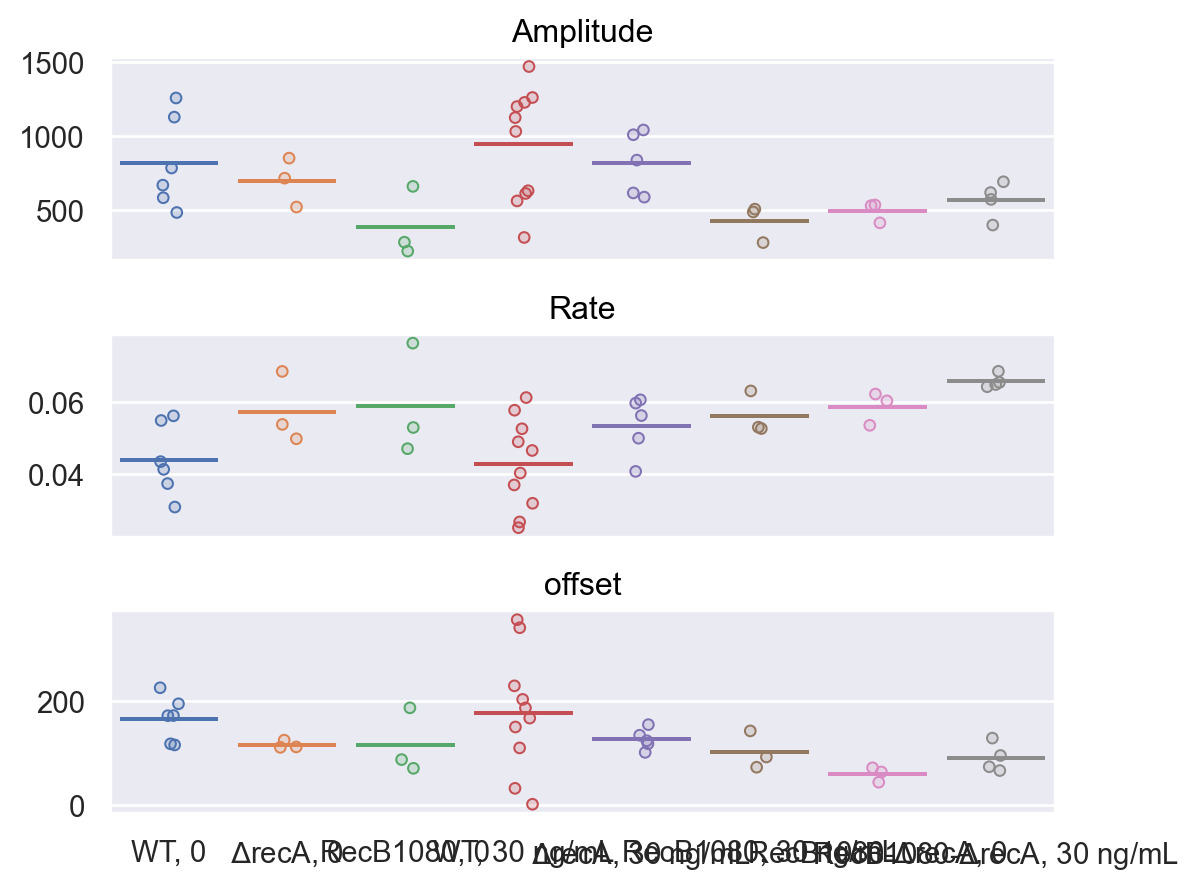

In [3]:
(
    so.Plot(bleaching_fit.parameters, x='Group', y='Value', color='Group')
    .facet(row='Parameter')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(), so.Agg(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

## RecB spot lifetime fit

### Bi-exponential fit

In [4]:
from pyberries.data import Fit, get_histogram
from pyberries.data import get_model
import pandas as pd

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.1, 0.1])

monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

#### Plot fits

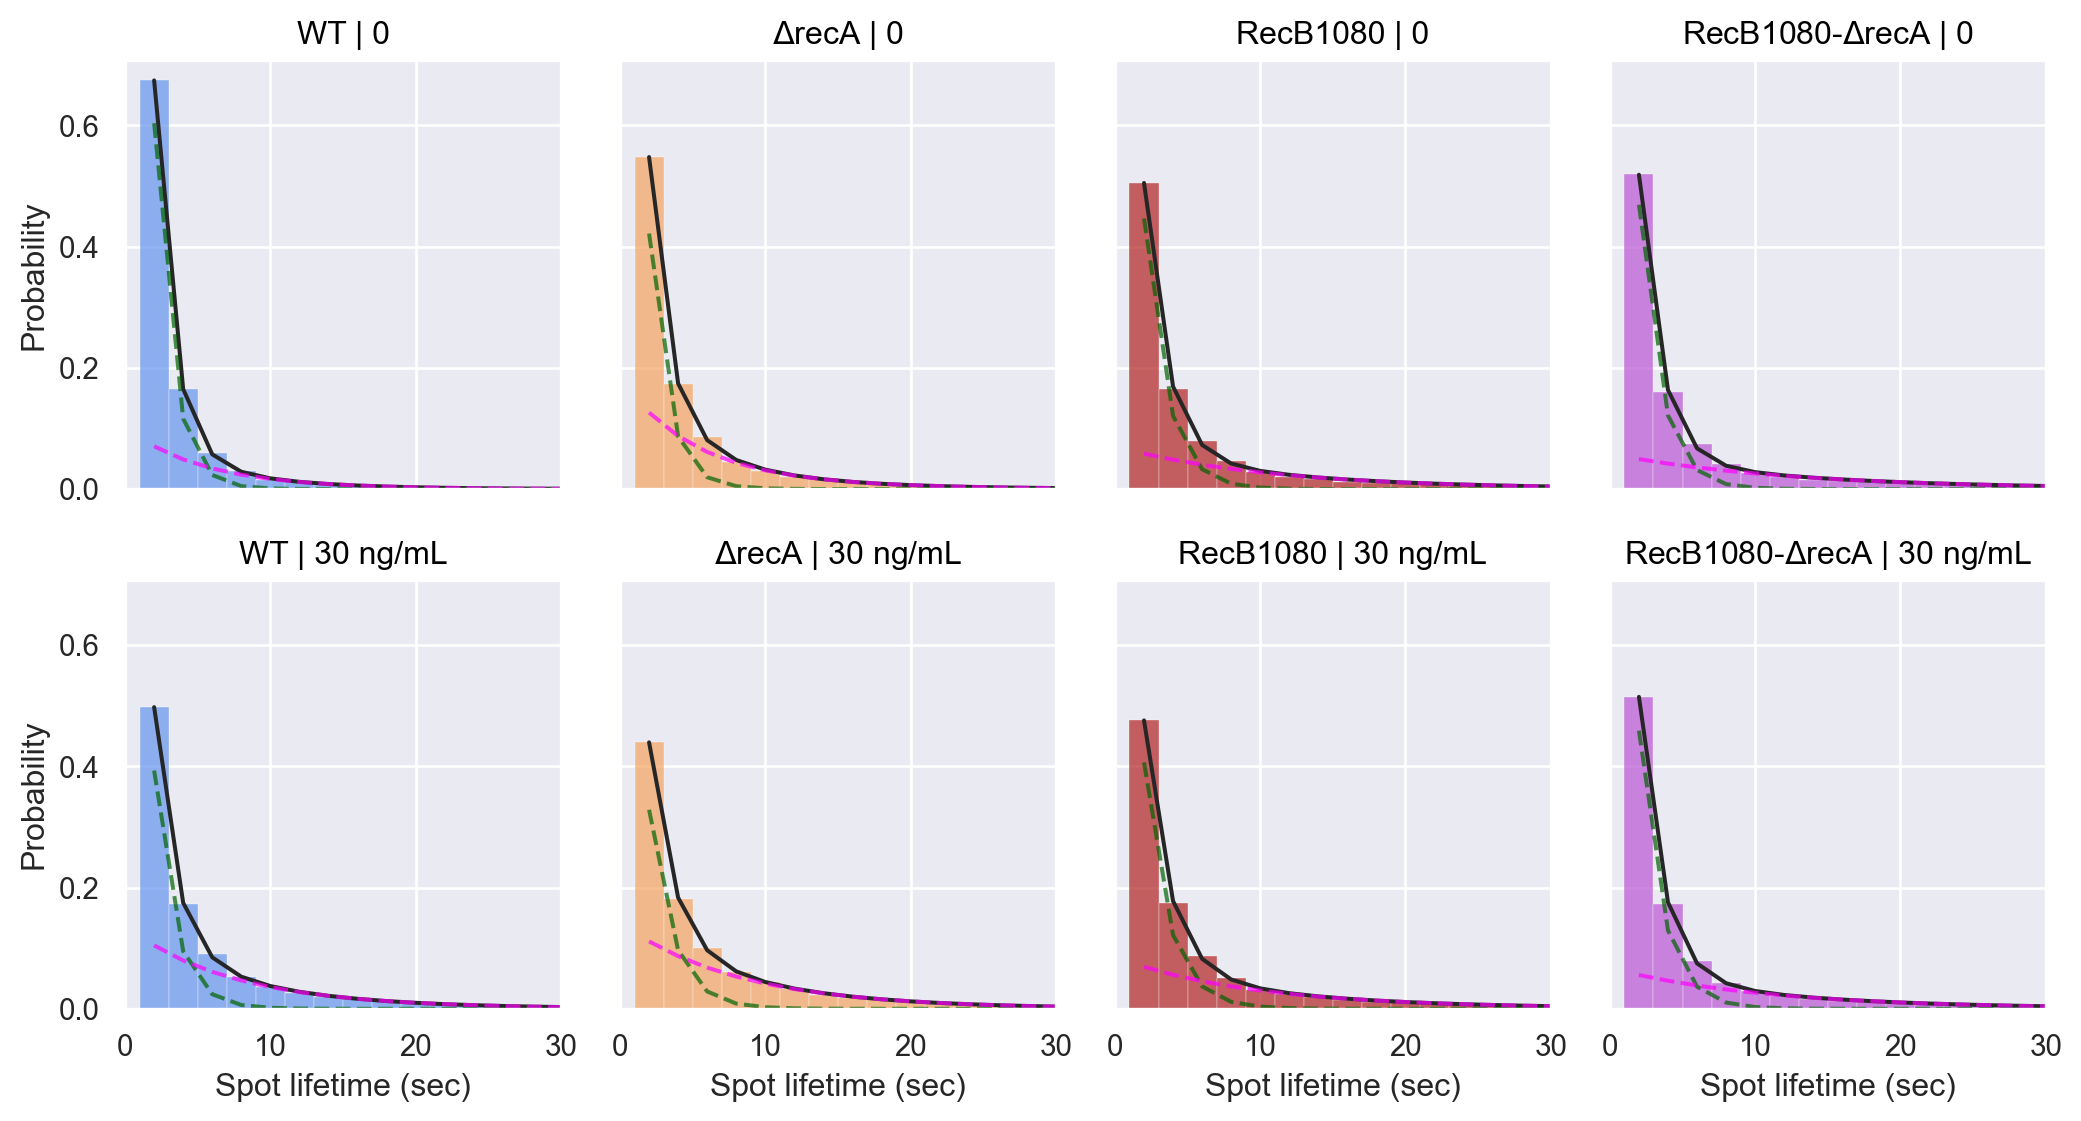

In [5]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength.mul(2))
      )

(
    so.Plot(df, x='TrackLength_s', color='Strain')
    .layout(size=(11, 6))
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid']))
    .label(x="Spot lifetime (sec)", y="Probability", color='')
    # .save(loc='D:\DanielThedie\Python\RecB_article\SI_Figures\Mutants_RecB_fits.pdf', format='pdf', bbox_inches='tight')
)

#### Proportion of spots with lifetime > 50 sec

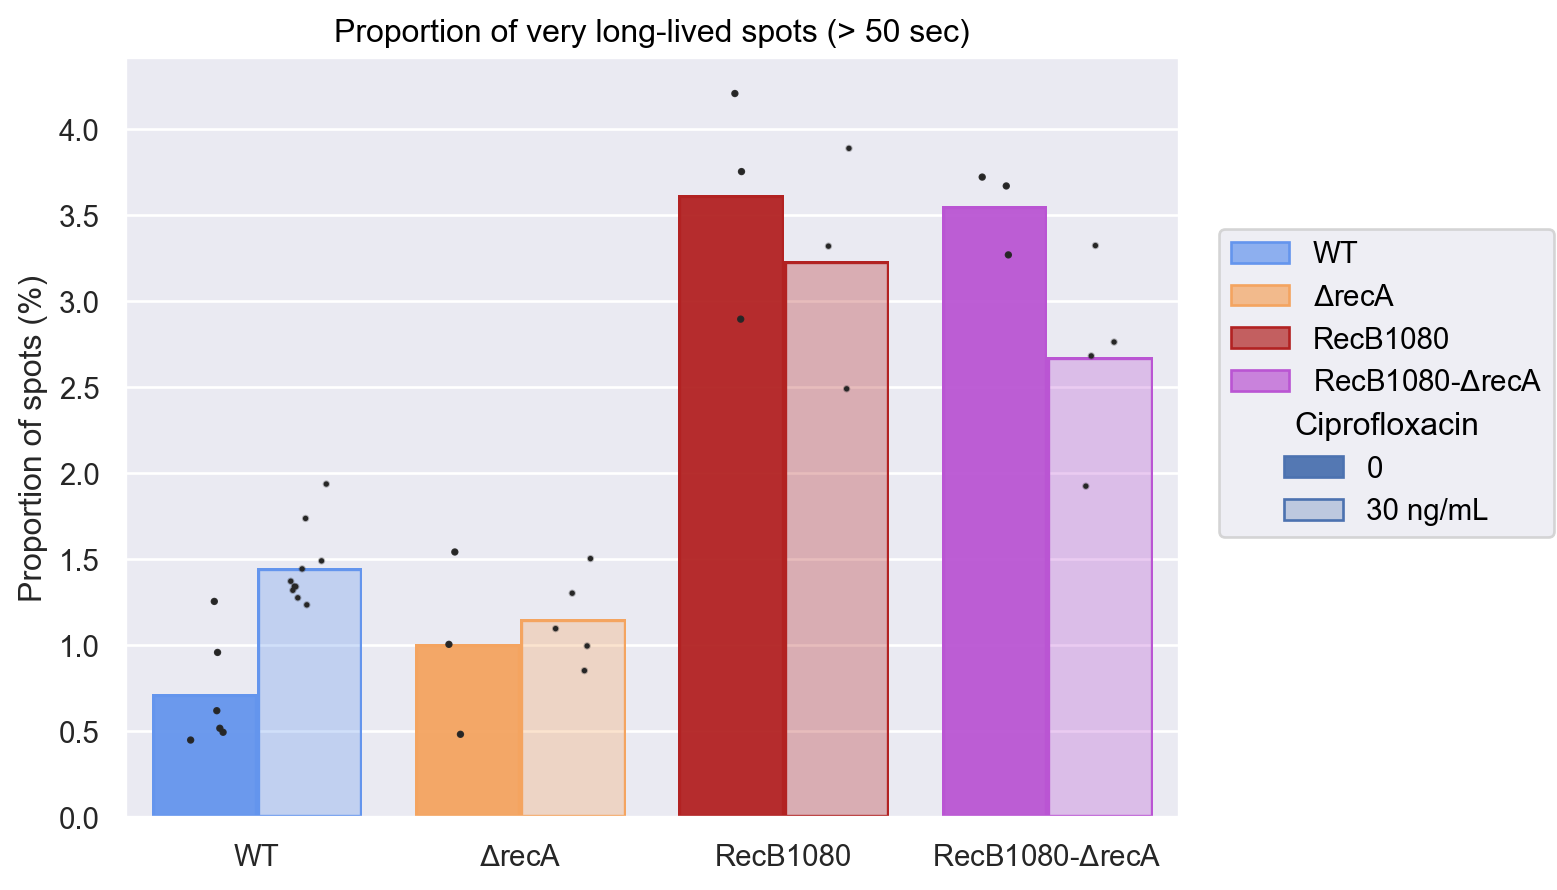

In [6]:
df = (data
      .RecB_spots
      .assign(vLong=lambda df: (df.TrackLength > 25).astype('int').mul(100))
      .groupby(['Group', 'Strain', 'Cipro', 'Dataset'])
      .agg({'vLong':'mean'})
      )

(
    so.Plot(df, x='Strain', y='vLong', color='Strain', alpha='Cipro')
    # .layout(size=(10,6))
    .add(so.Bar(), so.Agg('mean'), so.Dodge(by=['alpha']))
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'],
                            order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']),
           x=so.Nominal(order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Proportion of spots (%)", color='', title='Proportion of very long-lived spots (> 50 sec)', alpha='Ciprofloxacin')
)

#### Dissociation rates

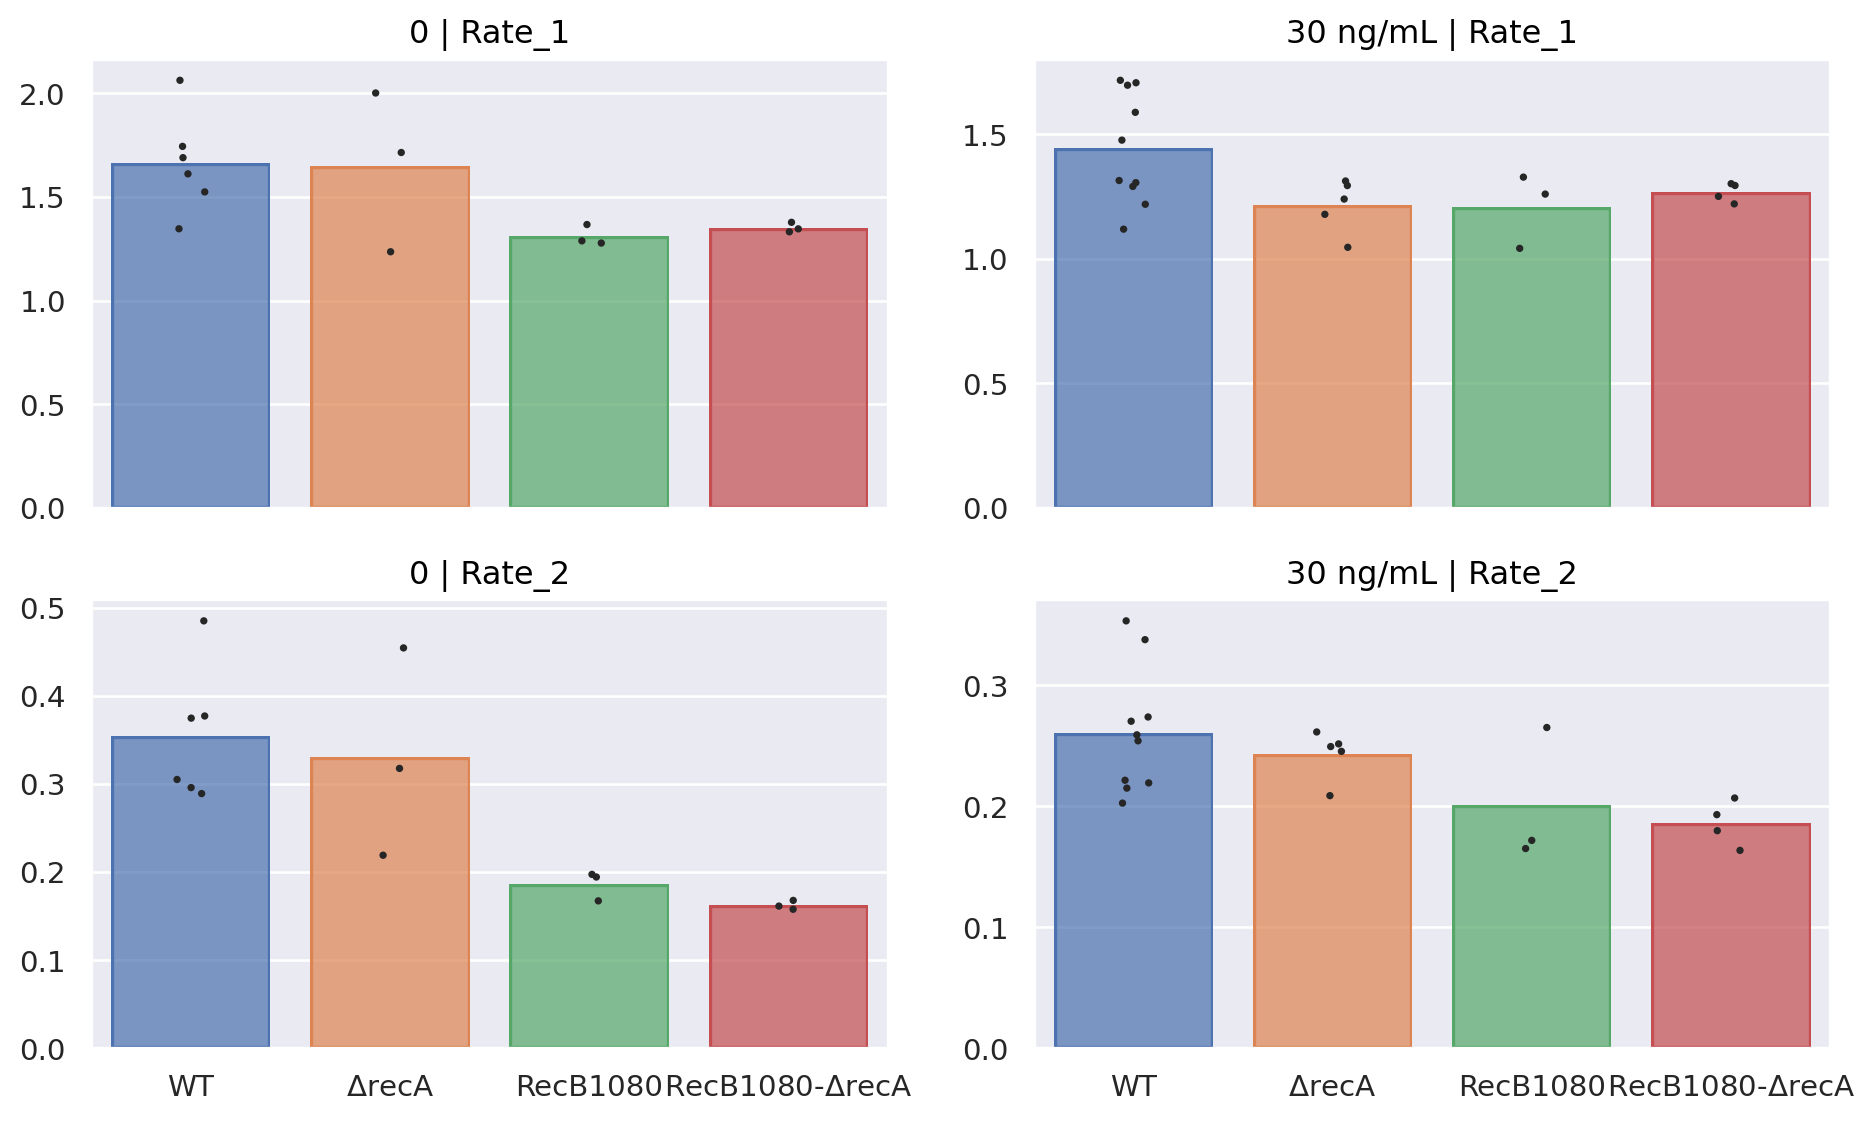

In [26]:
(
    so.Plot(lifetime_fit.parameters, x='Strain', y='Value', color='Strain')
    .layout(size=(10,6))
    .facet(row='Parameter', col='Cipro', order={'row':['Rate_1', 'Rate_2']})
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

#### Calculating RecB spot lifetimes from the rates

In [7]:
import pandas as pd

def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_biexp = (lifetime_fit
                   .parameters
                   .copy()
                   .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .replace({'1':'Short', '2':'Long'})
                   .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
                   .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Strain', 'Cipro', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
                   .reset_index()
                   .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                           Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                           Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                           Population_Short=lambda df: 100 - df.Population_Long
                           )
                   .drop(columns=['Value', 'Value_bleaching'], level=0)
                   .droplevel(['Parameter', 'Rate_type'], axis=1)
                   .melt(id_vars=['Strain', 'Cipro', 'Dataset'])
                   .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .drop(columns='variable')
                   )

#### Make a pretty lifetimes table

In [8]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes_biexp
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Strain', 'Cipro', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Strain', 'Cipro', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .reset_index()
      .assign(Strain=lambda df: df.Strain
                          .astype('category')
                          .cat.set_categories(['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA'], ordered=True))
      .sort_values('Strain')
      .set_index(['Strain','Cipro','Rate_type'])
      )

display(df)

Lifetime_mean  Lifetime_std  \
Strain                Cipro    Rate_type                                
WT                    0        Long                6.75          1.45   
                               Short               1.25          0.18   
                      30 ng/mL Long                9.53          1.89   
                               Short               1.46          0.23   
$\Delta$recA          0        Long                8.33          3.61   
                               Short               1.32          0.34   
                      30 ng/mL Long               10.57          1.67   
                               Short               1.72          0.16   
RecB1080              0        Long               15.90          2.27   
                               Short               1.60          0.07   
                      30 ng/mL Long               15.18          5.00   
                               Short               1.76          0.25   
RecB1080-$\Delta$recA 0        Long               19.37          1.65   
                               Short               1.55          0.03   
                      30 ng/mL Long               17.01          3.01   
                               Short               1.67          0.05   

                                          Population_mean  Population_std  
Strain                Cipro    Rate_type                                   
WT                    0        Long                  2.99            1.11  
                               Short                97.01            1.11  
                      30 ng/mL Long                  7.53            1.84  
                               Short                92.47            1.84  
$\Delta$recA          0        Long                  7.23            2.62  
                               Short                92.77            2.62  
                      30 ng/mL Long                 11.77            3.80  
                               Short                88.23            3.80  
RecB1080              0        Long                  4.11            1.09  
                               Short                95.89            1.09  
                      30 ng/mL Long                  5.86            1.72  
                               Short                94.14            1.72  
RecB1080-$\Delta$recA 0        Long                  3.11            0.29  
                               Short                96.89            0.29  
                      30 ng/mL Long                  4.01            0.78  
                               Short                95.99            0.78

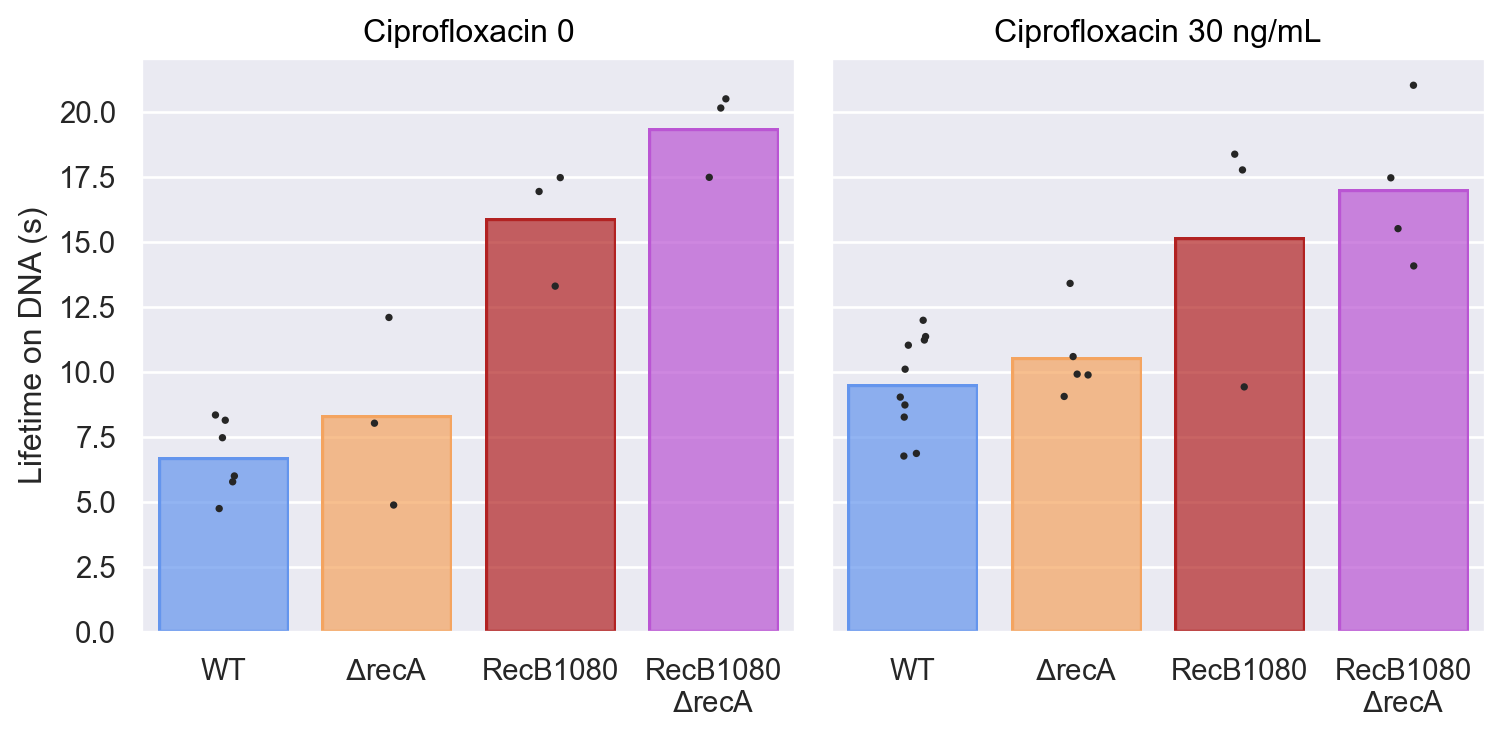

In [9]:
df = (lifetimes_biexp
      .replace({'Fast':'Short', 'Slow':'Long', 'RecB1080-$\Delta$recA':'RecB1080\n$\Delta$recA'})
      .query('Parameter == "Lifetime"  and Rate_type == "Long"')
      )

(
    so.Plot(df, x='Strain', y='value', color='Strain')
    .layout(size=(8, 4))
    .facet(col='Cipro')
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'],
                            order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA']),
           x=so.Nominal(order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title="Ciprofloxacin {}".format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

### Triple exponential fit

In [10]:
from pyberries.data import Fit, get_histogram
import numpy as np

def model(x, Amplitude_1, Rate_1, Amplitude_2, Rate_2, Amplitude_3, Rate_3):
    return Amplitude_1*np.exp(-Rate_1*x, dtype='float64') + Amplitude_2*np.exp(-Rate_2*x, dtype='float64') + Amplitude_3*np.exp(-Rate_3*x, dtype='float64')

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
triexp_fit = Fit(hist, x='TrackLength', y='proportion', model=model,
                 groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.5, 0.5, 0.1, 0.1])

Fit for dataset ('230725_2', 'WT, 0', 'WT', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Fit for dataset ('230719_1', 'WT, 0', 'WT', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Fit for dataset ('230201_DT22', '$\\Delta$recA, 0', '$\\Delta$recA', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Fit for dataset ('240424_3', '$\\Delta$recA, 0', '$\\Delta$recA', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Fit for dataset ('230118_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Fit for dataset ('230201_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Fit for dataset ('240424_2', 'WT, 30 ng/mL', 'WT', '30 ng/mL') fail

#### Plot fits

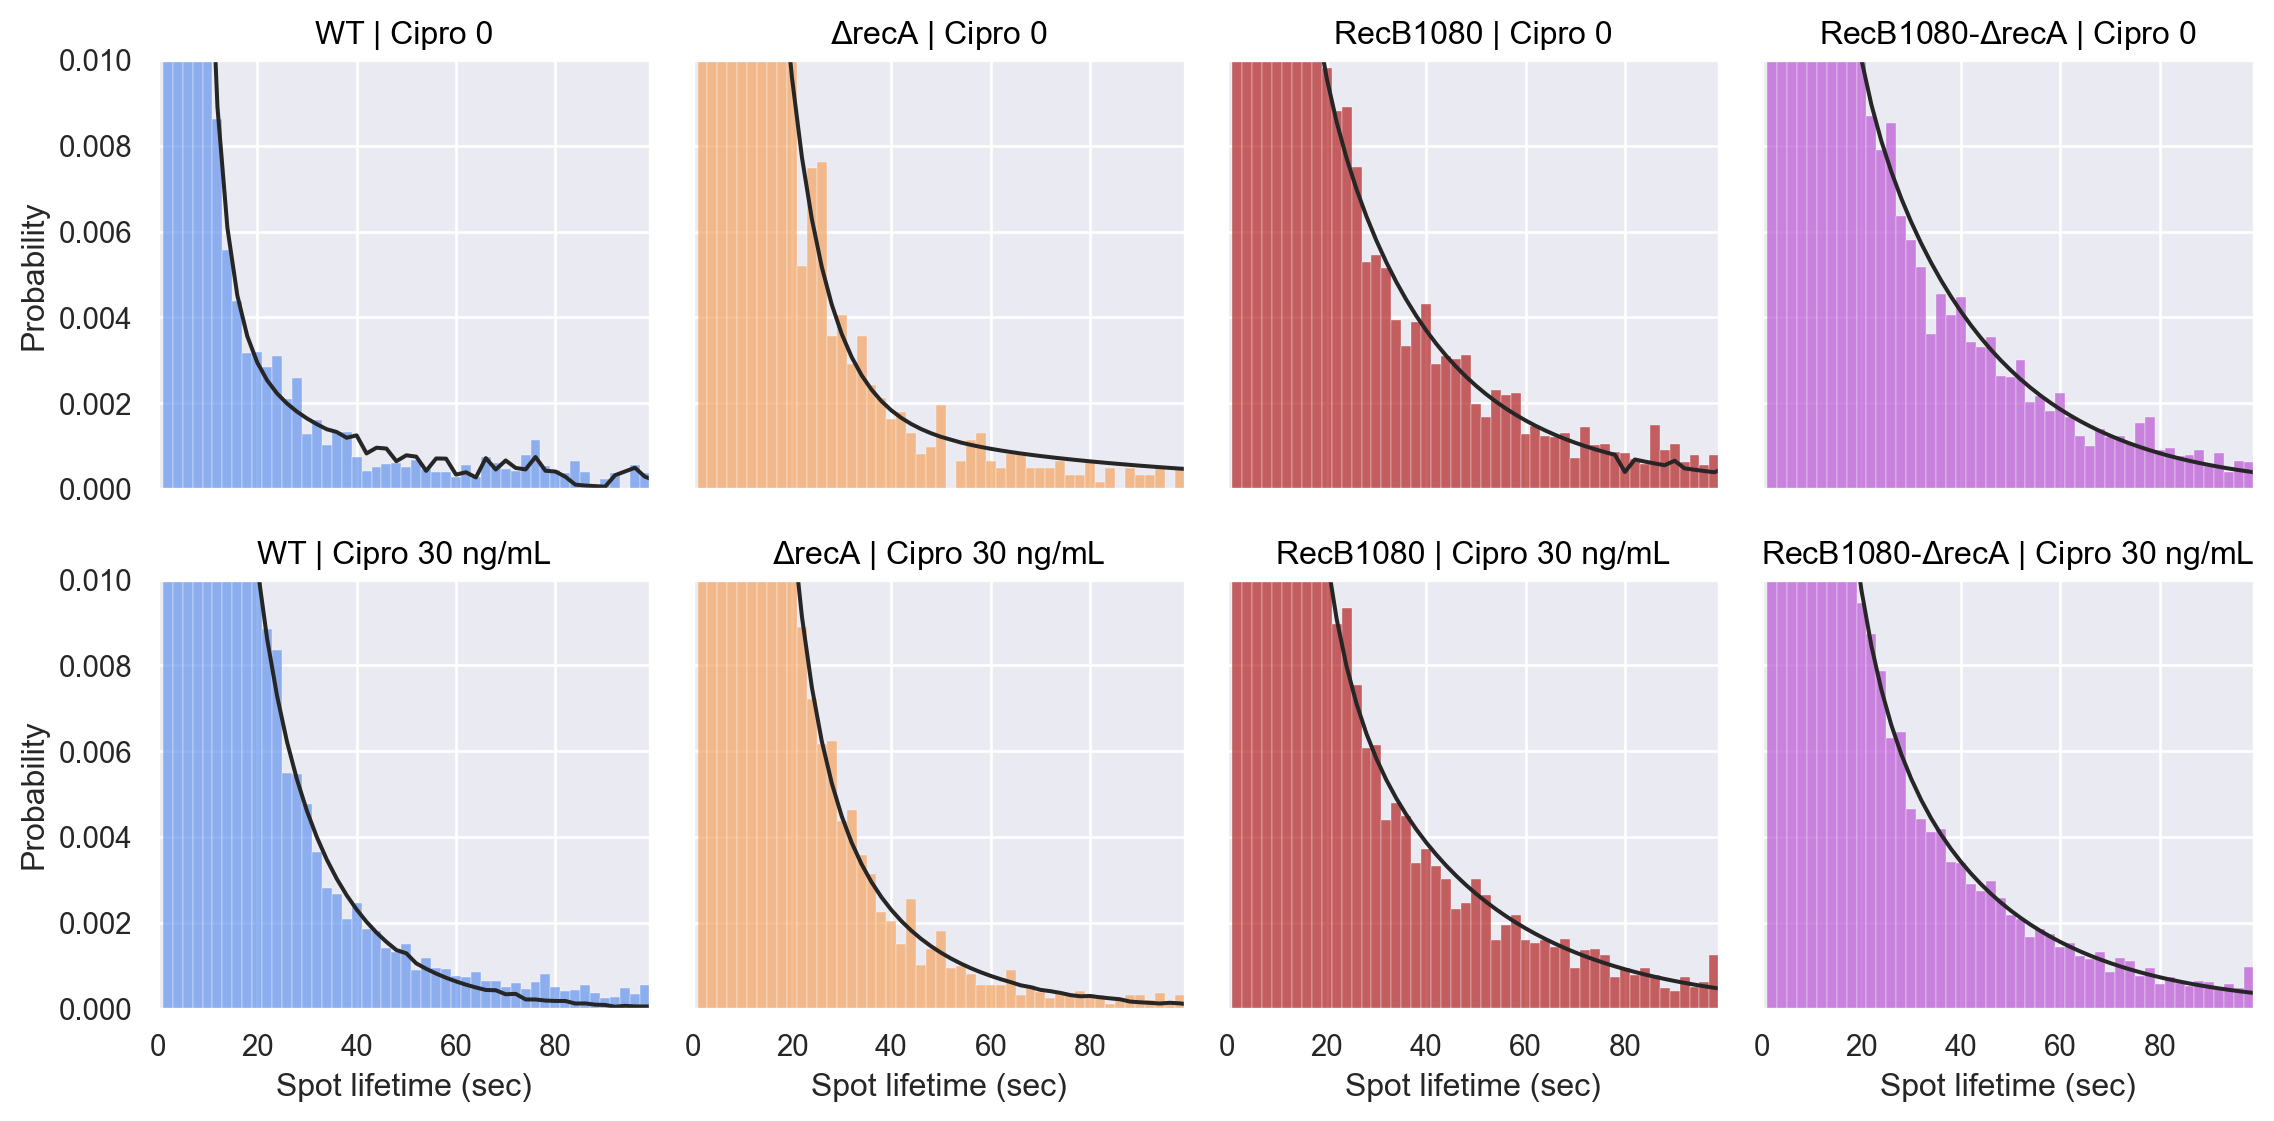

In [11]:
df = (triexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength.mul(2))
    #   .query('Dataset not in ["230725_1", "230126_DT23", "230919_2"]')
      )

(
    so.Plot(df, x='TrackLength_s', color='Strain')
    .layout(size=(12, 6))
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .limit(x=(0, 99), y=(None, 0.01))
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid']))
    .label(x="Spot lifetime (sec)", y="Probability", color='', row='{}'.format)
)

In [50]:
display(triexp_fit.parameters.query('Group == "RecB1080, 0"').groupby('Parameter')['Value'].agg('mean'))

Parameter
Amplitude_1    3.542709
Amplitude_2    0.577014
Amplitude_3    0.023971
Rate_1         2.767277
Rate_2         0.739517
Rate_3         0.089738
Name: Value, dtype: float64

#### Dissociation rates

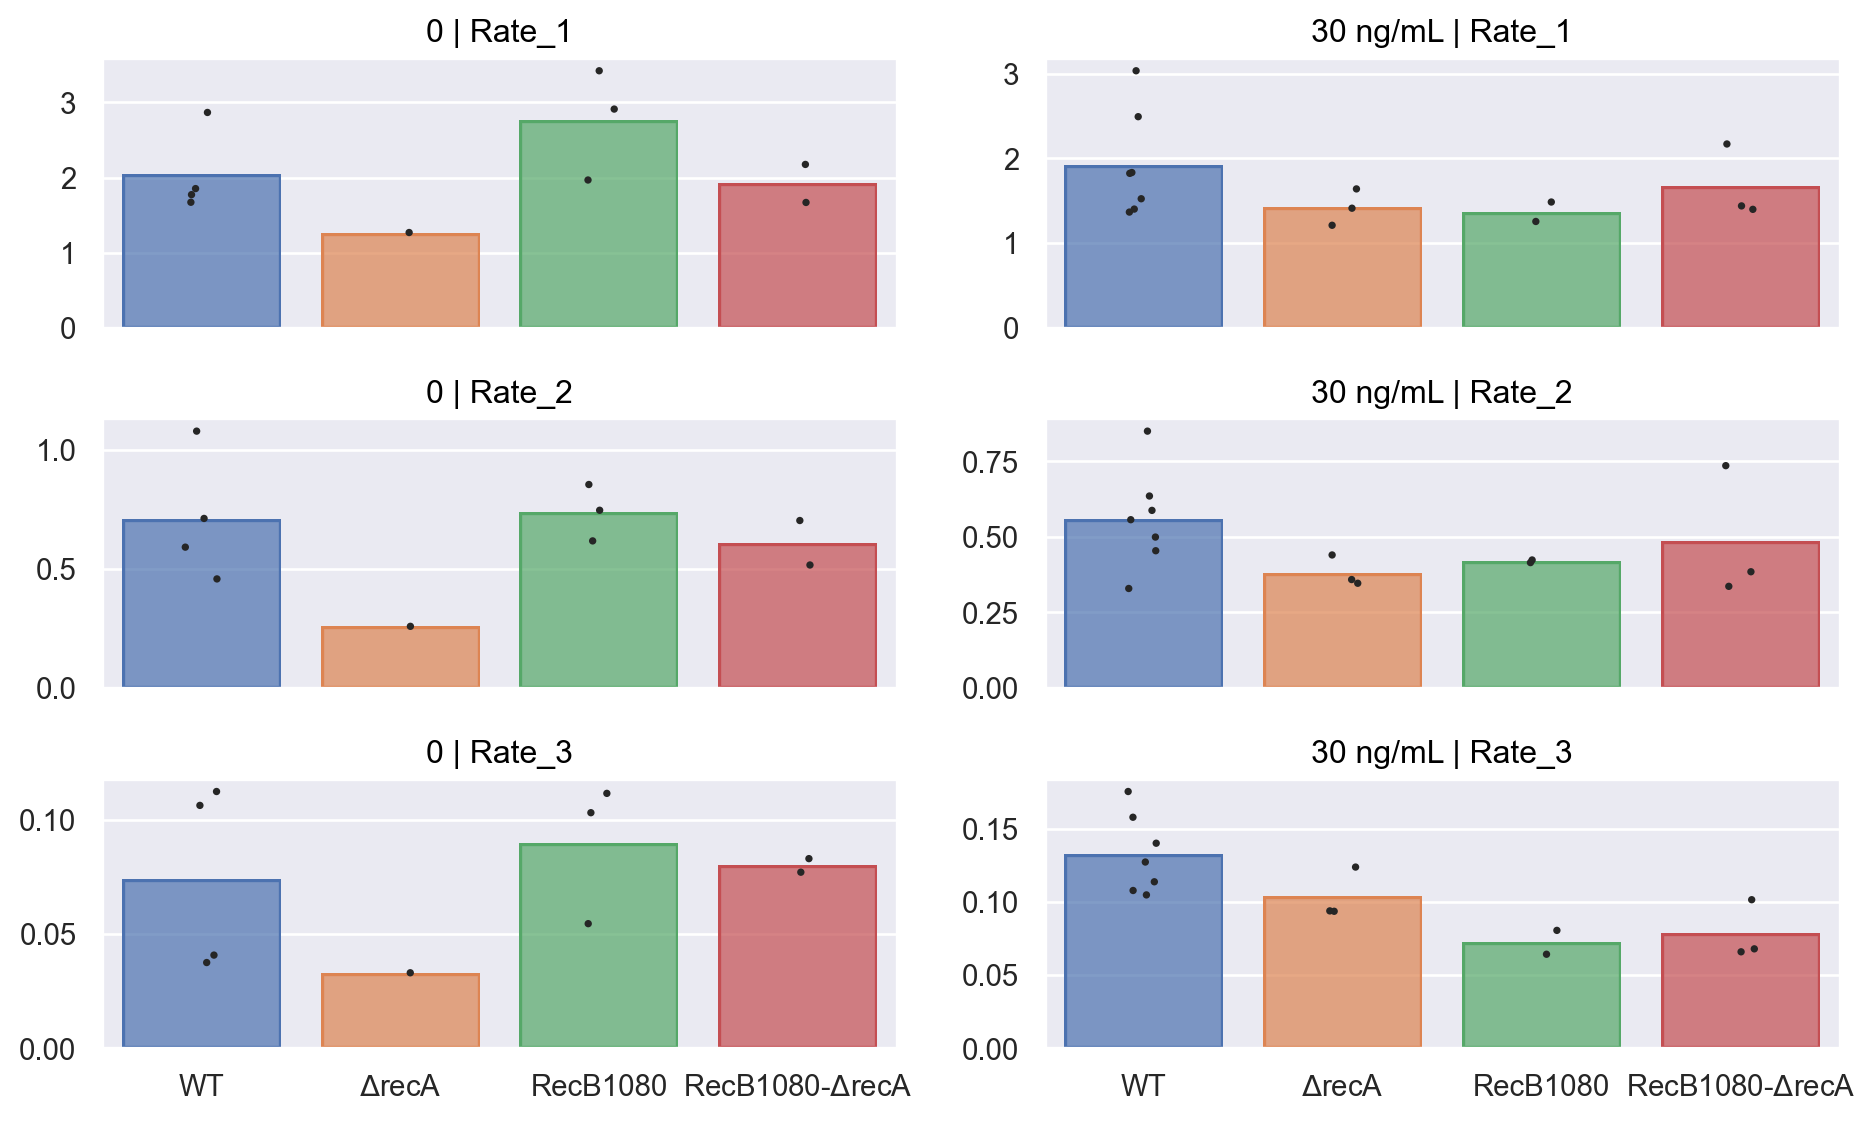

In [13]:
(
    so.Plot(triexp_fit.parameters, x='Strain', y='Value', color='Strain')
    .layout(size=(10,6))
    .facet(row='Parameter', col='Cipro', order={'row':['Rate_1', 'Rate_2', 'Rate_3']})
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

#### Very long-lived dissociation rates

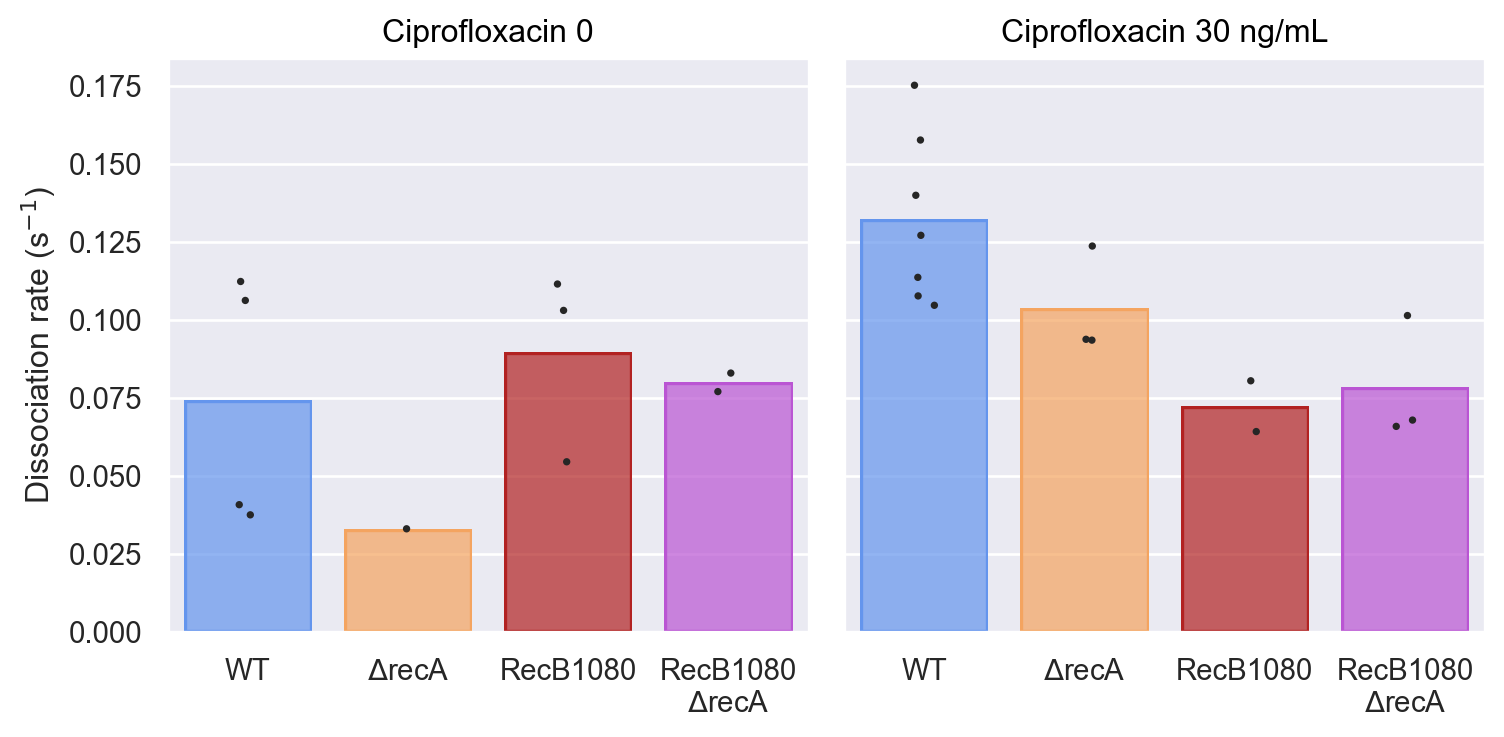

In [12]:
df = (triexp_fit
      .parameters
      .replace({'RecB1080-$\Delta$recA':'RecB1080\n$\Delta$recA'})
      .query("Parameter == 'Rate_3'")
      )

(
    so.Plot(df, x='Strain', y='Value', color='Strain')
    .layout(size=(8, 4))
    .facet(col='Cipro')
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'],
                            order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA']),
           x=so.Nominal(order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Dissociation rate (s$^{-1}$)", color='', title="Ciprofloxacin {}".format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

#### Computing RecB spot lifetimes from the rates

In [14]:
import pandas as pd

def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_triexp = (triexp_fit
                    .parameters
                    .copy()
                    .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                    .replace({'1':'Short', '2':'Long', '3':'VeryLong'})
                    .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
                    .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Strain', 'Cipro', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
                    .reset_index()
                    .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                            Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                            Lifetime_VeryLong=lambda df: 1/(df.Value.Rate.VeryLong - df.Value_bleaching) *2,
                            Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long+df.Value.Amplitude.VeryLong) *100,
                            Population_VeryLong=lambda df: df.Value.Amplitude.VeryLong/(df.Value.Amplitude.Short+df.Value.Amplitude.Long+df.Value.Amplitude.VeryLong) *100,
                            Population_Short=lambda df: 100 - df.Population_Long - df.Population_VeryLong
                            )
                    .drop(columns=['Value', 'Value_bleaching'], level=0)
                    .droplevel(['Parameter', 'Rate_type'], axis=1)
                    .melt(id_vars=['Strain', 'Cipro', 'Dataset'])
                    .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                    .drop(columns='variable')
                    )

#### Plot lifetimes

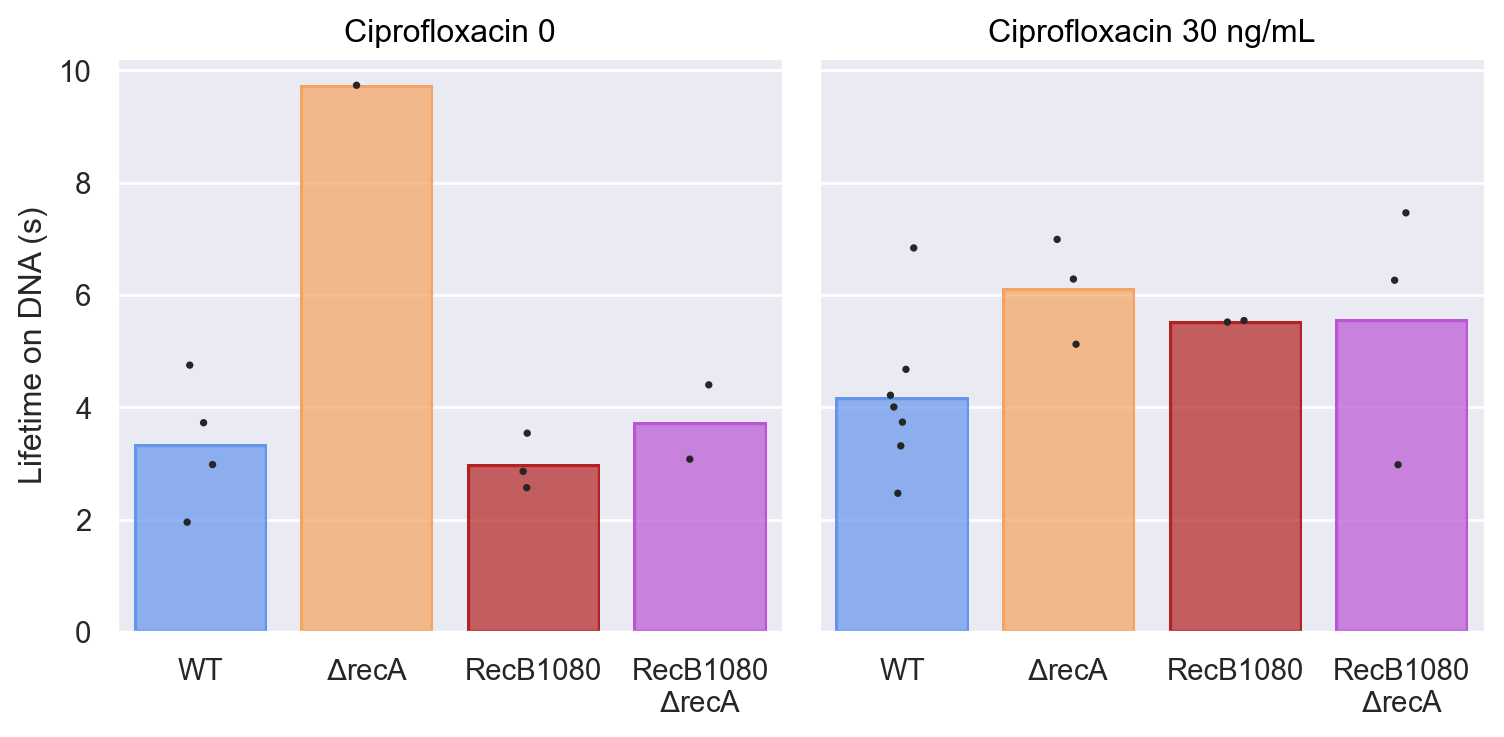

In [15]:
df = (lifetimes_triexp
      .replace({'Fast':'Short', 'Slow':'Long', 'RecB1080-$\Delta$recA':'RecB1080\n$\Delta$recA'})
      .query('Parameter == "Lifetime"  and Rate_type == "Long"')
      )

(
    so.Plot(df, x='Strain', y='value', color='Strain')
    .layout(size=(8, 4))
    .facet(col='Cipro')
    .add(so.Bar(), so.Agg('mean'), legend=False)
    .add(so.Dots(marker='.', color='k', fillalpha=1), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'],
                            order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA']),
           x=so.Nominal(order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA'])
           )
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title="Ciprofloxacin {}".format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

#### Chi-square test to check the relevance of a triple-exponential fit

In [ ]:
from scipy.stats import chi2

for grp in triexp_fit.llf.keys():
    LR_statistic = -2*(lifetime_fit.llf[grp] - triexp_fit.llf[grp])
    p_val = chi2.sf(LR_statistic, 2)
    print(f'{grp}: p-value = {p_val}')

## Number of spots per cell area

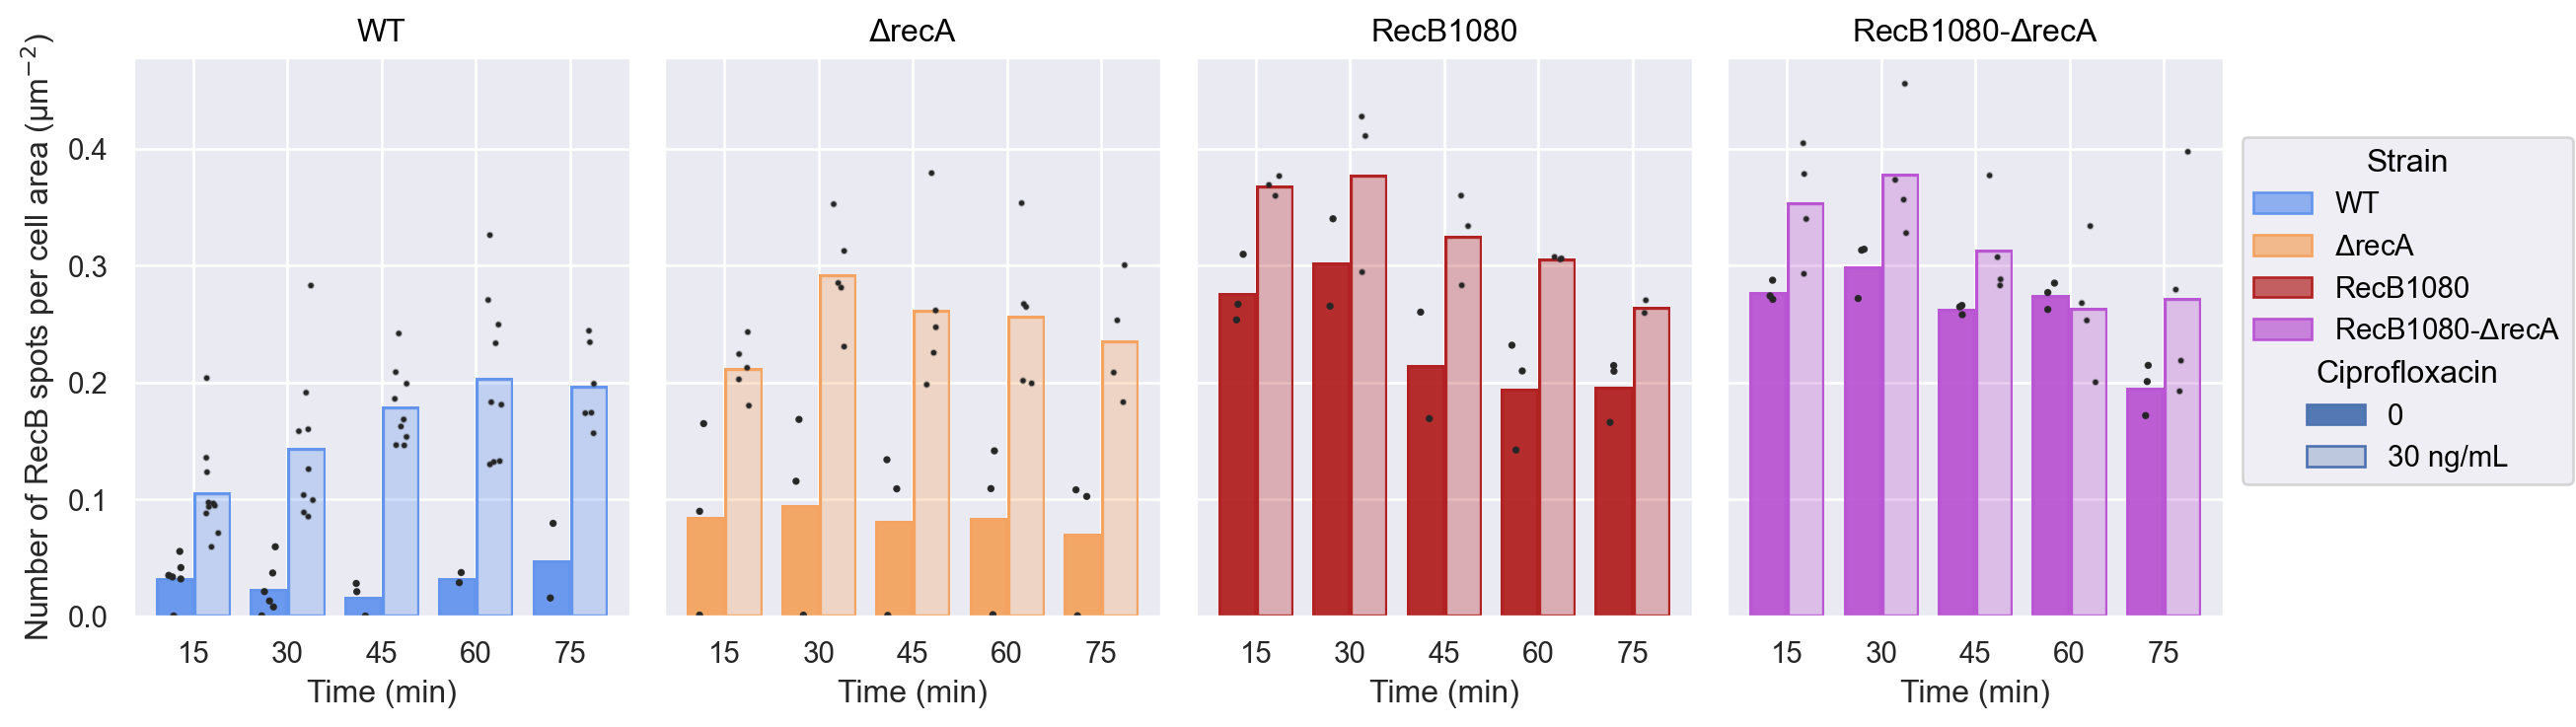

In [16]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .assign(object_name='RecB_spots',
              long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
              )
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'Area': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area)
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'long_spot', 'Time_min_bin'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells)
      .query('Time_min_bin < 90 and long_spot == "Long"')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Strain', alpha='Cipro')
 .layout(size=(12, 4))
 .facet(col='Strain', order={'col':['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']})
 .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
 .scale(alpha=so.Nominal(),
        color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'], order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']),
        x=so.Continuous().tick(every=15)
        )
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", color='Strain', alpha='Ciprofloxacin')
#  .save(loc='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_counting_long_short.svg', format='svg', bbox_inches='tight')
 )

### More compact graph

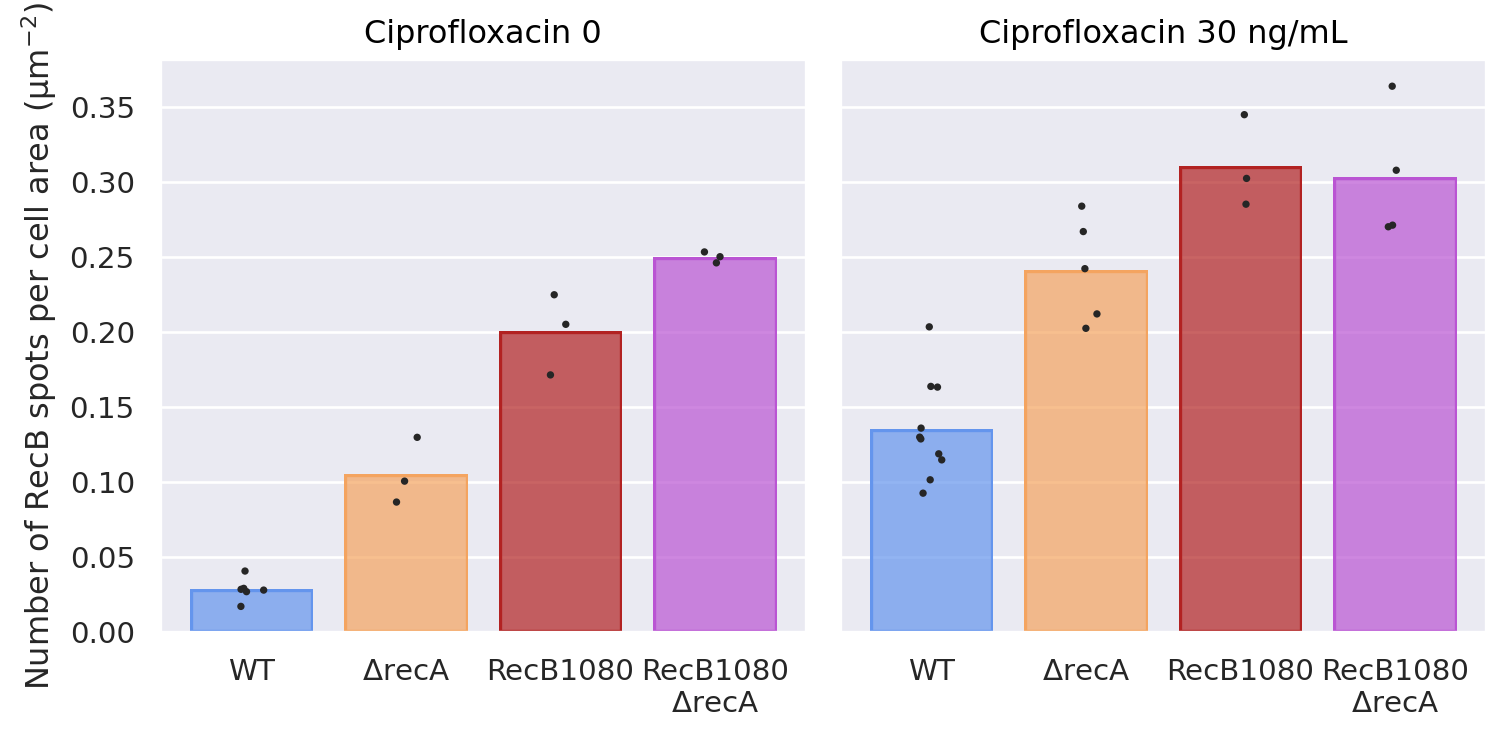

In [31]:
df = (data
      .assign(object_name='RecB_spots',
               long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
               )
      .get_parent_indices(object_name='RecB_spots')
      .RecB_spots
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'SpineLength': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.SpineLength)
      .groupby(by=['Strain', 'Cipro', 'long_spot', 'Dataset'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby('Dataset')['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on='Dataset',
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,
              norm_count=lambda df: df.norm_count / df.nCells
              )
      .query('long_spot == "Long"')
      .replace({'RecB1080-$\Delta$recA':'RecB1080\n$\Delta$recA'})
      )

(
 so.Plot(df, x='Strain', y='norm_count', color='Strain')
 .layout(size=(8, 4))
 .facet(col='Cipro')
 .add(so.Bar(), so.Agg('mean'), legend=False)
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'], order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA']),
        x=so.Nominal(order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080\n$\Delta$recA'])
        )
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x='', y='Number of RecB spots per cell area (µm$^{-2}$)', title='Ciprofloxacin {}'.format, color='Strain')
#  .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_counting.svg', format='svg', bbox_inches='tight')
 )

## RecB position in the cell

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

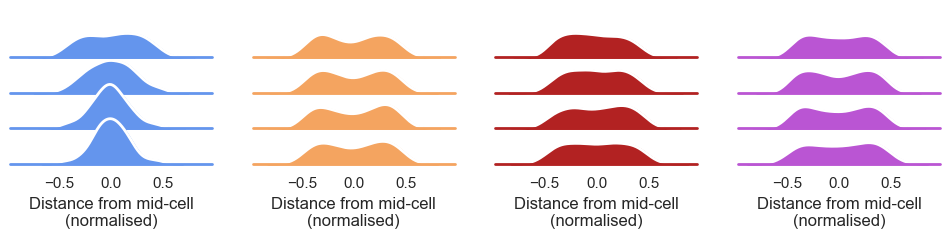

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .assign(object_name='RecB_spots', midCellDist=lambda df: df.SpineCurvilinearCoord / df.SpineLength - 0.5)
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=20, binlabels='left')
      .RecB_spots
      .query('Time_min_bin < 95 and Cipro == "30 ng/mL" and TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Group", aspect=6, height=.5, palette=['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "midCellDist",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "midCellDist", clip_on=False, color="w", lw=2, bw_adjust=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

# g.map(label, "midCellDist")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)

# plt.savefig(fname='D:\\DanielThedie\\Figures\\RecB_article_figures\\4_Mutants\\RecB_position.svg', format='svg', bbox_inches='tight')